# Cycle Scoring
This notebook shows how to use autora.cycle scoring tools.

We'll be using the [Iris toy dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-plants-dataset) from sklearn to create a simple logistic regression cycle. This model will classify samples into different species of irises based on flower measurements. The dataset will be split between a training set and test set; the test set will be withheld for the scoring metrics.

In [1]:
import random
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn.pipeline as skp
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.datasets import load_iris
from functools import partial

from autora.variable import VariableCollection, Variable
from autora.experimentalist.sampler import random_sampler
from autora.experimentalist.pipeline import Pipeline
from autora.cycle import Cycle, cycle_default_score, cycle_specified_score, plot_cycle_score

### Importing Data
Data is split where 33% is reserved for testing.

In [2]:
# Import and split data
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=1)

### Cycle Setup
1. **Theorist** - Uses sklearn's `Pipeline` to create a logistic regression estimator with a scaling pre-processing step.
2. **Experimentalist** - Uses autora's `Pipeline` to create a random sampling experimentalist with the training dataset's independent variables (`X_train`) as the condition pool.
3. **Experiment Runner** - Creates an oracle that uses the full dataset to match experimental independent variables (flower measurements) and returns the dependent variable (species).

In [3]:
# Set up cycle and run
# Variable Metadata
random.seed(1)
study_metadata = VariableCollection(
    independent_variables=[
        Variable(name='sepal length', units='cm', value_range=(4.3, 7.9)),
        Variable(name='sepal width', units='cm', value_range=(2.0, 4.4)),
        Variable(name='petal length', units='cm', value_range=(1.0, 6.9)),
        Variable(name='petal width', units='cm', value_range=(0.1, 2.5)),
    ],
    dependent_variables=[Variable(name="species", allowed_values=[0,1,2])],
)

# Theorist
clf = skp.Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression())])

# Experimentalist
# Note that the pool is only the training split
experimentalist = Pipeline(
        [
            ("pool", X_train),
            ("sampler", random_sampler),
        ],
        params={
            "sampler": {"n": 5},
        },
    )

# Experiment Runner
def oracle(xs, X_truth, y_truth):
    l_idx = []

    for condition in xs:
        l_idx.append(np.where((X_truth[:,0] == condition[0]) &
                              (X_truth[:,1] == condition[1]) &
                              (X_truth[:,2] == condition[2]) &
                              (X_truth[:,3] == condition[3]))[0][0]
                     )

    l_return = y_truth[l_idx].ravel()
    return l_return

experiment_runner = partial(oracle, X_truth=X, y_truth=y)

cycle = Cycle(
        metadata=study_metadata,
        theorist=clf,
        experimentalist=experimentalist,
        experiment_runner=experiment_runner
)

# Run cycle 20 times
cycle.run(20)

### Scoring Metrics
We can score the models in two ways:
1. Estimator's default scoring metric - Sklearn estimators have a default scoring method.
    -`LogisticRegression()` default is [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)
2. Scoring functions - Sklearn has many available [scoring functions](https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules). It is up to the user to determine what is compatible with their model.

Autora has two functions to return scoring metrics of each cycle:
1. `cycle_default_score` - Uses the estimator's default
2. `cycle_specified_score` - Uses the one of Sklearn's scoring functions



In [4]:
results_default = cycle_default_score(cycle, X_test, y_test)
print(f'Default scorer: {results_default}\n')

results_specified_accuracy = cycle_specified_score(accuracy_score, cycle, X_test, y_test)
print(f'Specified scorer1: {results_specified_accuracy}\n')

results_specified_precision = cycle_specified_score(precision_score, cycle, X_test, y_test, average='weighted', zero_division=0)
print(f'Specified scorer2: {results_specified_precision}')

Default scorer: [0.74, 0.8, 0.84, 0.86, 0.88, 0.84, 0.84, 0.84, 0.92, 0.94, 0.9, 0.92, 0.96, 0.96, 0.96, 0.96, 0.96, 0.98, 0.96, 0.96]

Specified scorer1: [0.74, 0.8, 0.84, 0.86, 0.88, 0.84, 0.84, 0.84, 0.92, 0.94, 0.9, 0.92, 0.96, 0.96, 0.96, 0.96, 0.96, 0.98, 0.96, 0.96]

Specified scorer2: [0.7716666666666667, 0.8151111111111112, 0.8454411764705883, 0.8701470588235294, 0.896888888888889, 0.8727692307692309, 0.8727692307692309, 0.856, 0.9251470588235294, 0.9415555555555555, 0.9103676470588234, 0.9251470588235294, 0.96, 0.96, 0.96, 0.96, 0.96, 0.981, 0.96, 0.96]


Note that the "default scorer" and "specified scorer 1" results should be the same because the `LogisticRegression` estimator's default is the `accuracy_score` function.

### Plotting
These scores can be plotted using autora's `plot_cycle_score`.
* The plotter will use the estimator's default scorer unless a `scorer` keyword is supplied with a sklearn scoring function.
* Additional parameters for scoring functions are supplied with the `scorer_kw` as a dictionary.

Below are several examples.

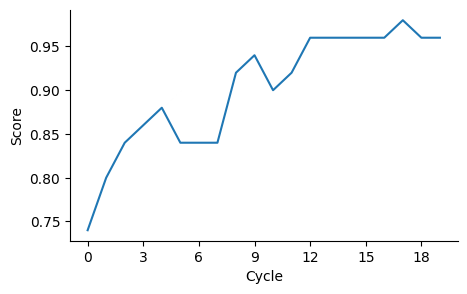

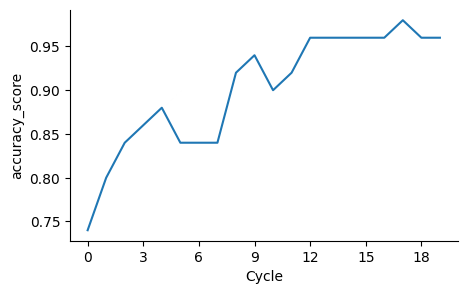

In [5]:
# Default
plot_cycle_score(cycle, X_test, y_test,
                 figsize=(5,3));
# Specifying Scorer - Plots should be the identical.
plot_cycle_score(cycle, X_test, y_test,
                 scorer=accuracy_score,
                 figsize=(5,3));

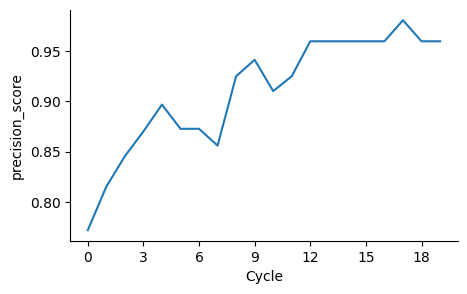

In [6]:
# Precision
plot_cycle_score(cycle, X_test, y_test,
                 scorer=precision_score,
                 figsize=(5,3),
                 scorer_kw=dict(average='weighted', zero_division=0));

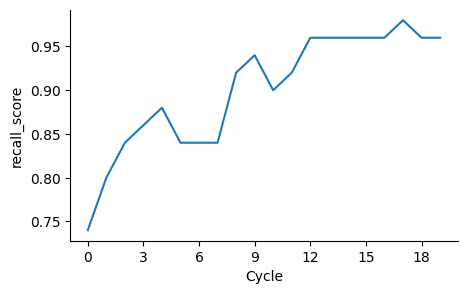

In [7]:
# Recall
plot_cycle_score(cycle, X_test, y_test,
                 scorer=recall_score,
                 figsize=(5,3),
                 scorer_kw=dict(average='weighted'));

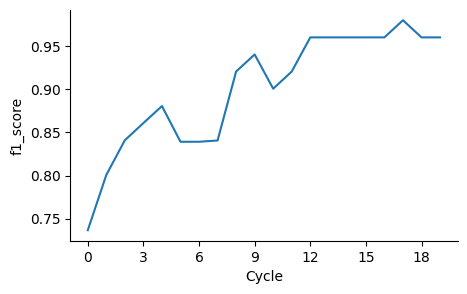

In [8]:
# F1
plot_cycle_score(cycle, X_test, y_test,
                 scorer=f1_score,
                 figsize=(5,3),
                 scorer_kw=dict(average='weighted'));

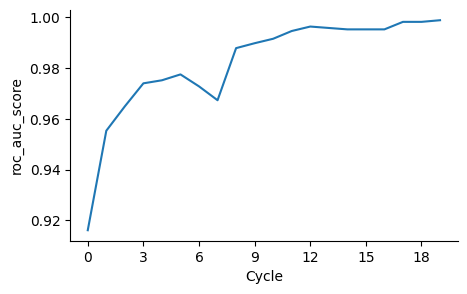

In [9]:
# ROC Area Under Curve
plot_cycle_score(cycle, X_test, y_test,
                 scorer=roc_auc_score,
                 figsize=(5,3),
                 scorer_kw=dict(average='weighted', multi_class='ovr'));

Text(0.5, 1.0, 'Accuracy Over 20 Cycles')

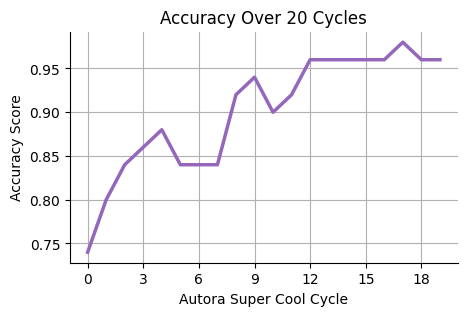

In [10]:
# Customization
fig = plot_cycle_score(cycle, X_test, y_test,
                       x_label = 'Autora Super Cool Cycle',
                       y_label= 'Accuracy Score',
                       scorer=accuracy_score,
                       figsize=(5,3),
                       plot_kw=dict(linewidth=2.5, color='tab:purple'),
                       );
fig.axes[0].grid()
fig.axes[0].set_title('Accuracy Over 20 Cycles')
